In [186]:
import csv
from itertools import groupby
from typing import NamedTuple, Dict, Tuple
import matplotlib.pyplot as plt

class LookupEntry(NamedTuple):
    absolute: float
    relative: float
    win: int
    rank: int
    race: str
    opp_race: str

class InfoEntry(NamedTuple):
    uid: str
    race: str
    rank: int
    win: int

def bucket(val, size):
    return val // size * size

def convert_rank(rank):
    return int(rank) if rank in ['1', '2', '3', '4', '5', '6', '7'] else 0

def filename_to_gameid(replay_file):
    game_id = replay_file.split("_")[1].split(".")[0]
    if replay_file.startswith("ggg"):
        game_id = "ggg-" + game_id
    elif replay_file.startswith("spawningtool"):
        game_id = "st-" + game_id
    elif replay_file.startswith("dropsc"):
        game_id = "ds-" + game_id
    return game_id

with open("replays_info.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
# there's one replay that doesn't have rank information...
infos = {filename_to_gameid(line["ReplayID"]): {
    line["UID1"]: InfoEntry(line["UID1"], line["Race1"], convert_rank(line["Rank1"]), 1 if line["Winner"] == "1" else 0),
    line["UID2"]: InfoEntry(line["UID2"], line["Race2"], convert_rank(line["Rank2"]), 1 if line["Winner"] == "2" else 0),
} for line in lines if len(line["Rank1"]) > 0}

with open("sc2_prediction_data2021-07-31.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
stats = {key: list(g) for key, g in 
         groupby(sorted(lines, key=lambda x: x['GameID']), 
                 lambda x: x['GameID'])}

APM_BUCKET_SIZE = 5
CPM_BUCKET_SIZE = 1
apm_lookup = {}
cpm_lookup = {}
for game, s in stats.items():
    assert len(s) == 2
    assert game in infos
    assert s[0]['UID'] in infos[game]
    assert int(s[0]["Win"]) == infos[game][s[0]['UID']].win
    assert convert_rank(s[0]["Rank"]) == infos[game][s[0]['UID']].rank or convert_rank(s[0]["Rank"]) == 7, f"{s[0]}\n{infos[game][s[0]['UID']]}"
    assert s[1]['UID'] in infos[game]
    assert int(s[1]["Win"]) == infos[game][s[1]['UID']].win    
    assert convert_rank(s[1]["Rank"]) == infos[game][s[1]['UID']].rank  or convert_rank(s[1]["Rank"]) == 7
    apm_lookup[(s[0]['UID'], s[0]['GameID'])] = LookupEntry(bucket(float(s[0]["APM"]), APM_BUCKET_SIZE), 
                                                            bucket(float(s[0]["APM"]) - float(s[1]["APM"]), 
                                                                   APM_BUCKET_SIZE), 
                                                            int(s[0]["Win"]), convert_rank(s[0]["Rank"]),
                                                            infos[game][s[0]['UID']].race, 
                                                            infos[game][s[1]['UID']].race)
    apm_lookup[(s[1]['UID'], s[1]['GameID'])] = LookupEntry(bucket(float(s[1]["APM"]), APM_BUCKET_SIZE), 
                                                            bucket(float(s[1]["APM"]) - float(s[0]["APM"]), 
                                                                   APM_BUCKET_SIZE), 
                                                            int(s[1]["Win"]), convert_rank(s[1]["Rank"]),
                                                            infos[game][s[1]['UID']].race, 
                                                            infos[game][s[0]['UID']].race)
    cpm0 = float(s[0]["cps"]) * 60
    cpm1 = float(s[1]["cps"]) * 60
    cpm_lookup[(s[0]['UID'], s[0]['GameID'])] = LookupEntry(bucket(cpm0, CPM_BUCKET_SIZE), 
                                                            bucket(cpm0 - cpm1, CPM_BUCKET_SIZE), 
                                                            int(s[0]["Win"]), convert_rank(s[0]["Rank"]),
                                                            infos[game][s[0]['UID']].race, 
                                                            infos[game][s[1]['UID']].race)
    cpm_lookup[(s[1]['UID'], s[1]['GameID'])] = LookupEntry(bucket(cpm1, CPM_BUCKET_SIZE), 
                                                            bucket(cpm1 - cpm0, CPM_BUCKET_SIZE), 
                                                            int(s[1]["Win"]), convert_rank(s[1]["Rank"]),
                                                            infos[game][s[1]['UID']].race, 
                                                            infos[game][s[0]['UID']].race)

def count_scouting(scouting, gameid, uid):
    return len([x for x in scouting.get(gameid, []) if x['UID'] == uid])
    

with open("scouting_instances2021-08-02.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]
scouting = {key: list(g) for key, g in 
            groupby(sorted(lines, key=lambda x: x['GameID']), 
                    lambda x: x['GameID']) if key in stats}

scouting_lookup = {}
for game, s in scouting.items():
    stat0, stat1 = stats[game]
    count0 = count_scouting(scouting, game, stat0['UID'])
    count1 = count_scouting(scouting, game, stat1['UID'])
    scouting_lookup[(stat0['UID'], stat0['GameID'])] = LookupEntry(count0, count0 - count1, 
                                                                   int(stat0["Win"]), convert_rank(stat0["Rank"]),
                                                                   infos[game][stat0['UID']].race, 
                                                                   infos[game][stat1['UID']].race)
    scouting_lookup[(stat1['UID'], stat1['GameID'])] = LookupEntry(count1, count1 - count0,
                                                                   int(stat1["Win"]), convert_rank(stat1["Rank"]),
                                                                   infos[game][stat1['UID']].race,
                                                                   infos[game][stat0['UID']].race)

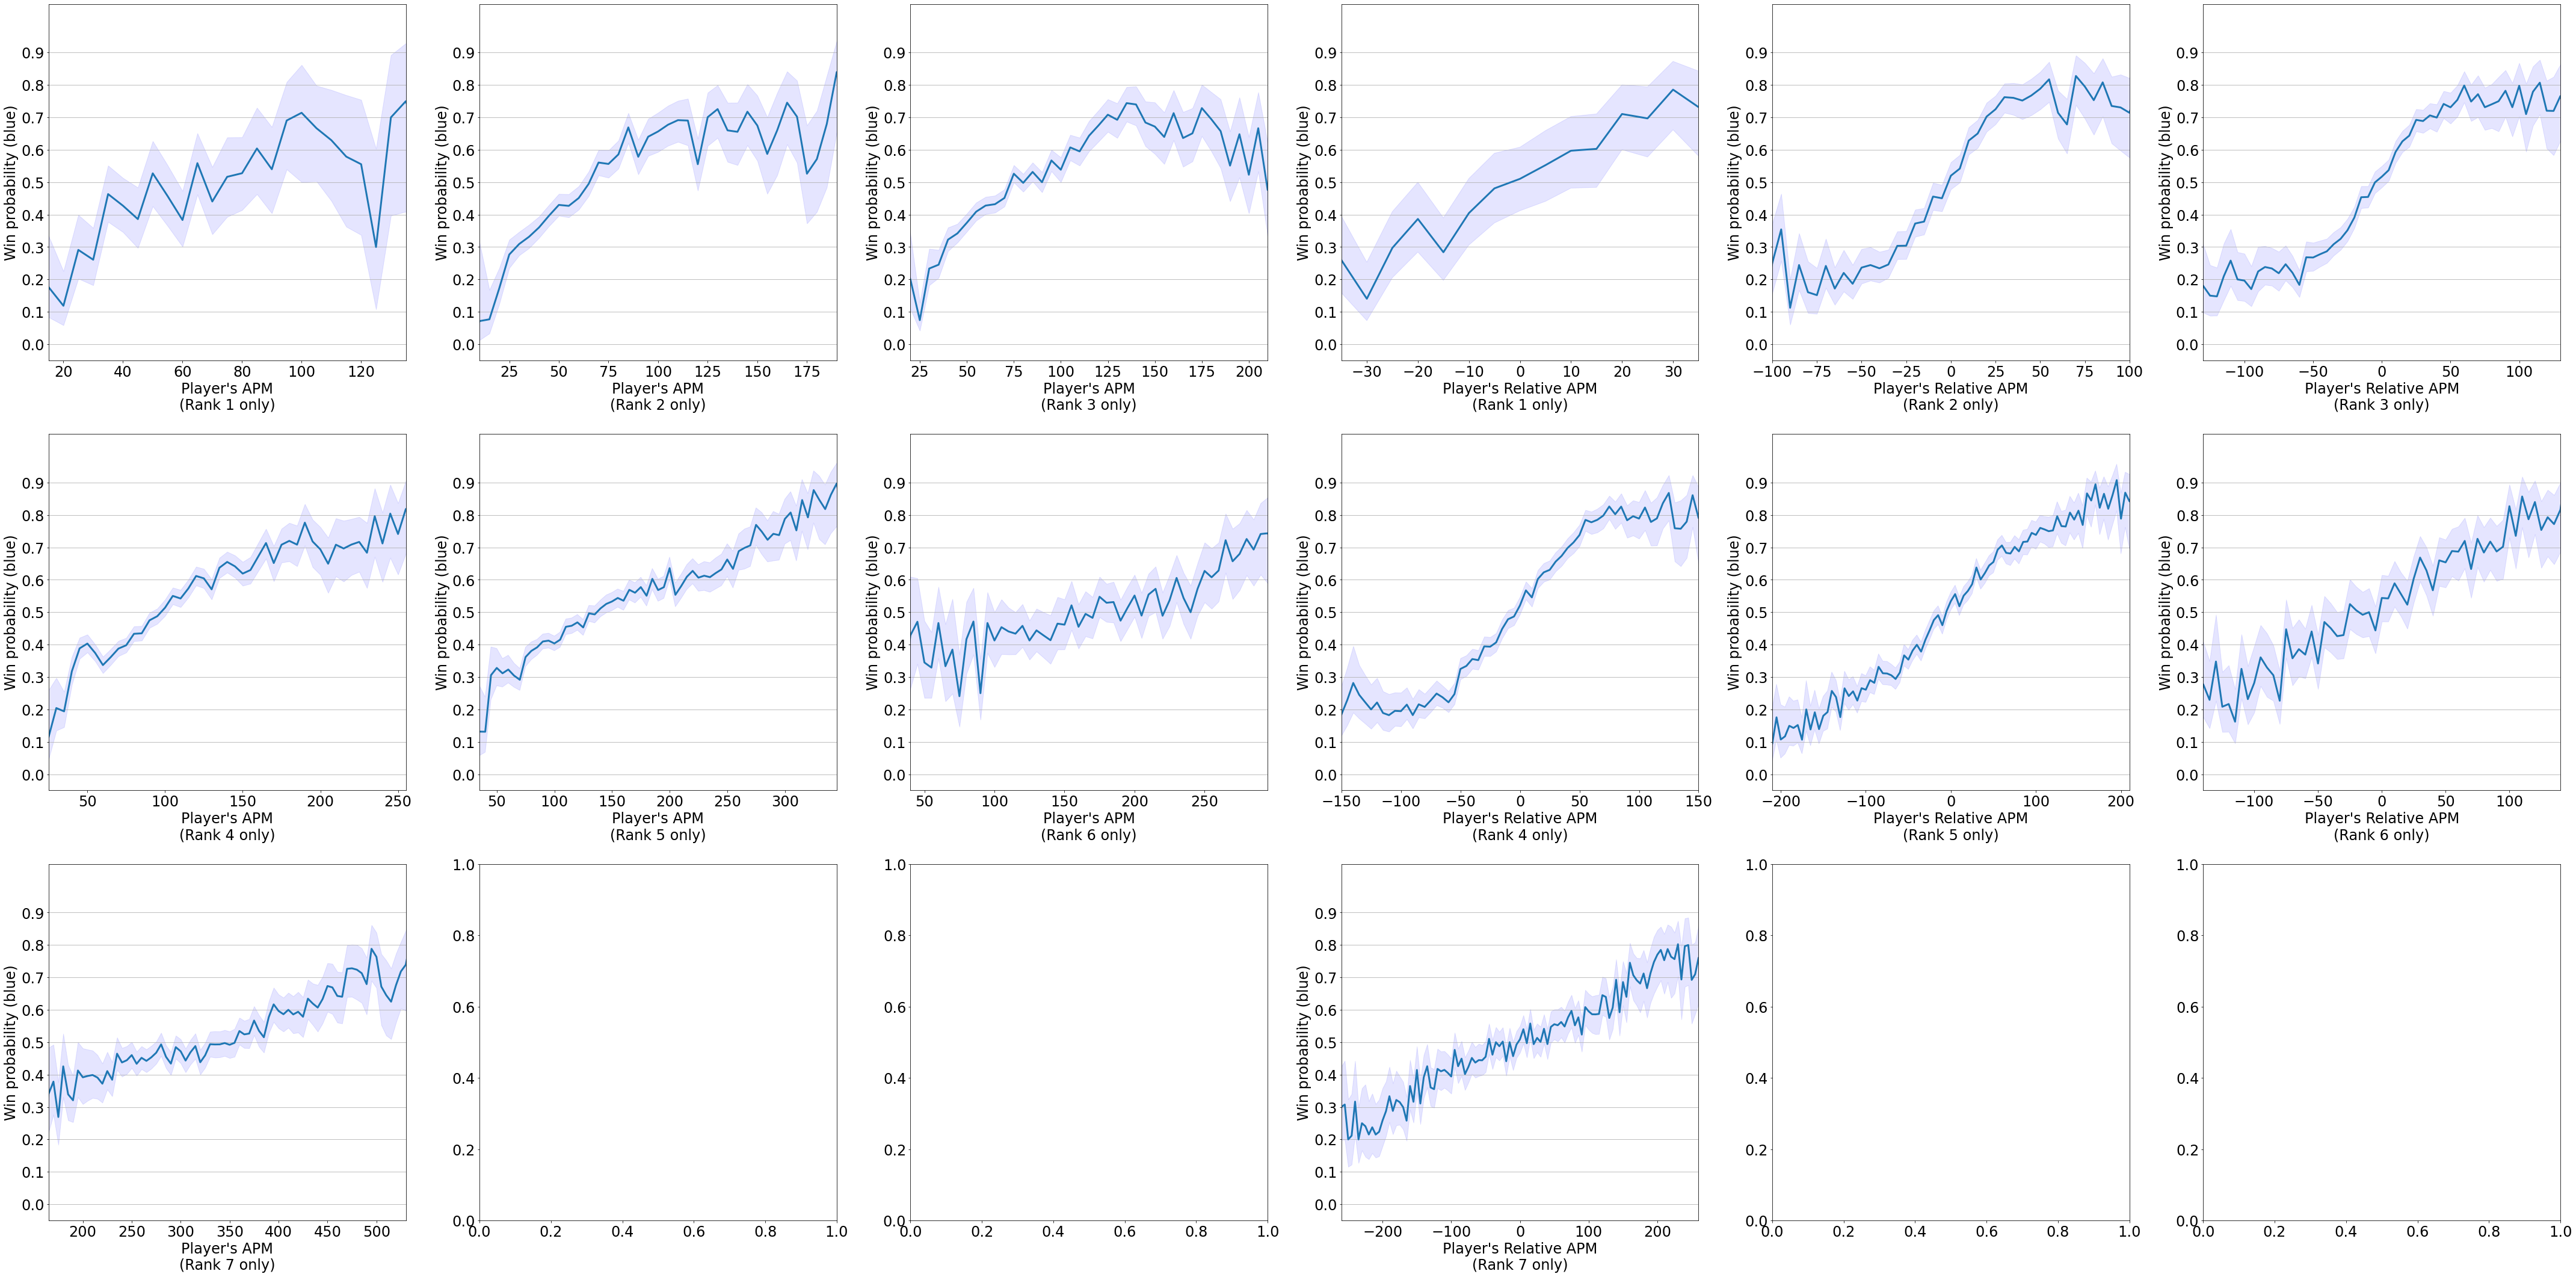

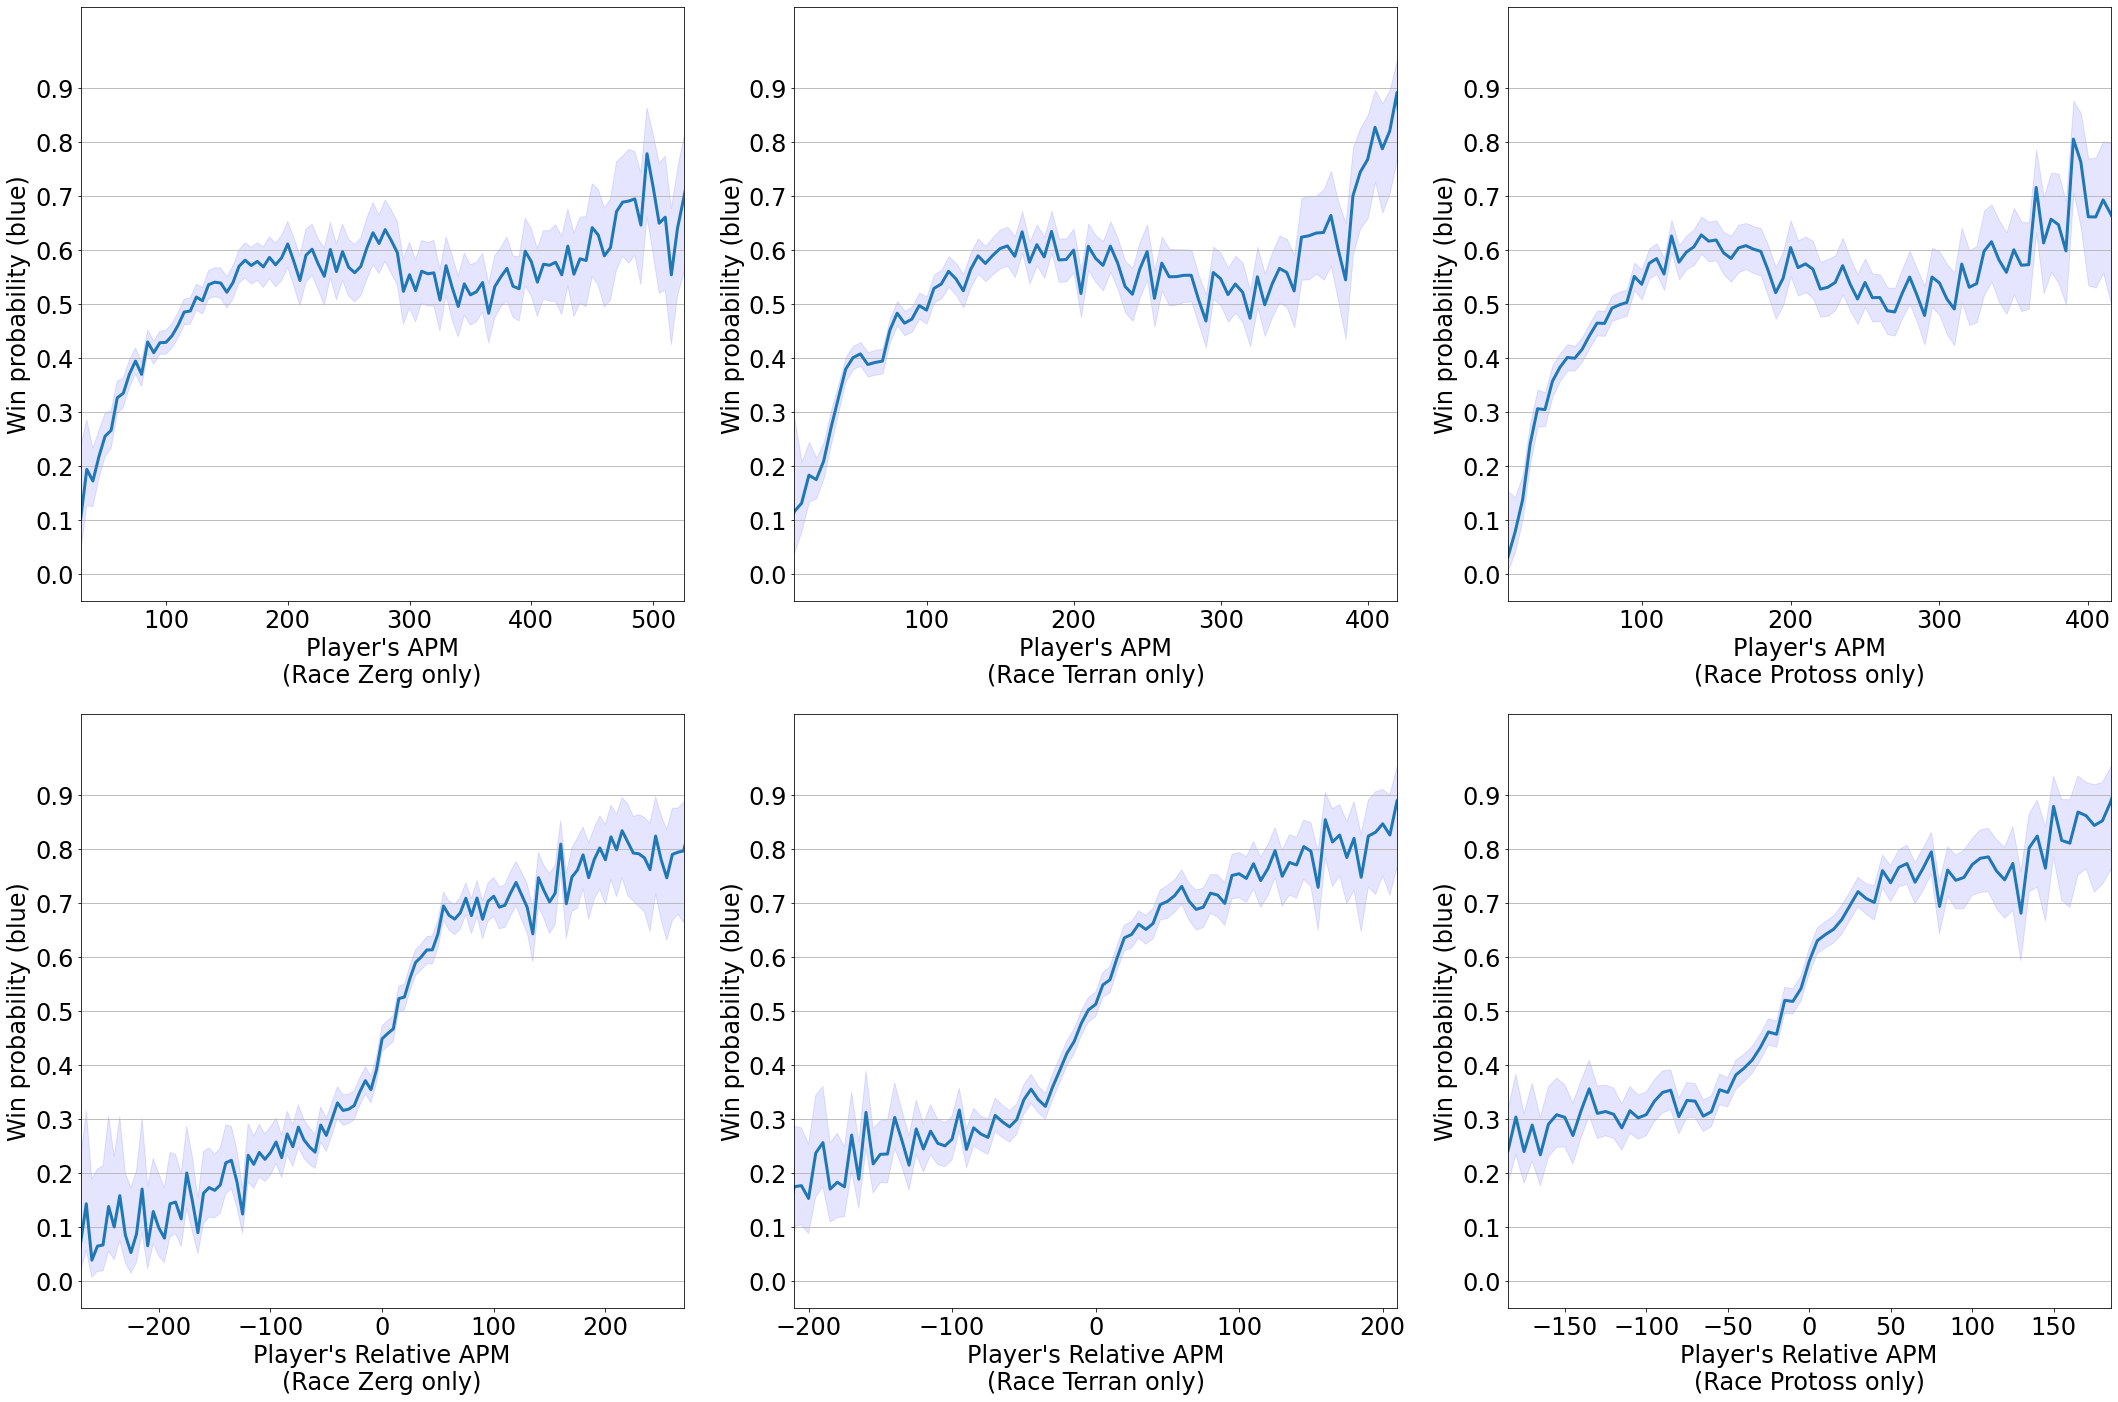

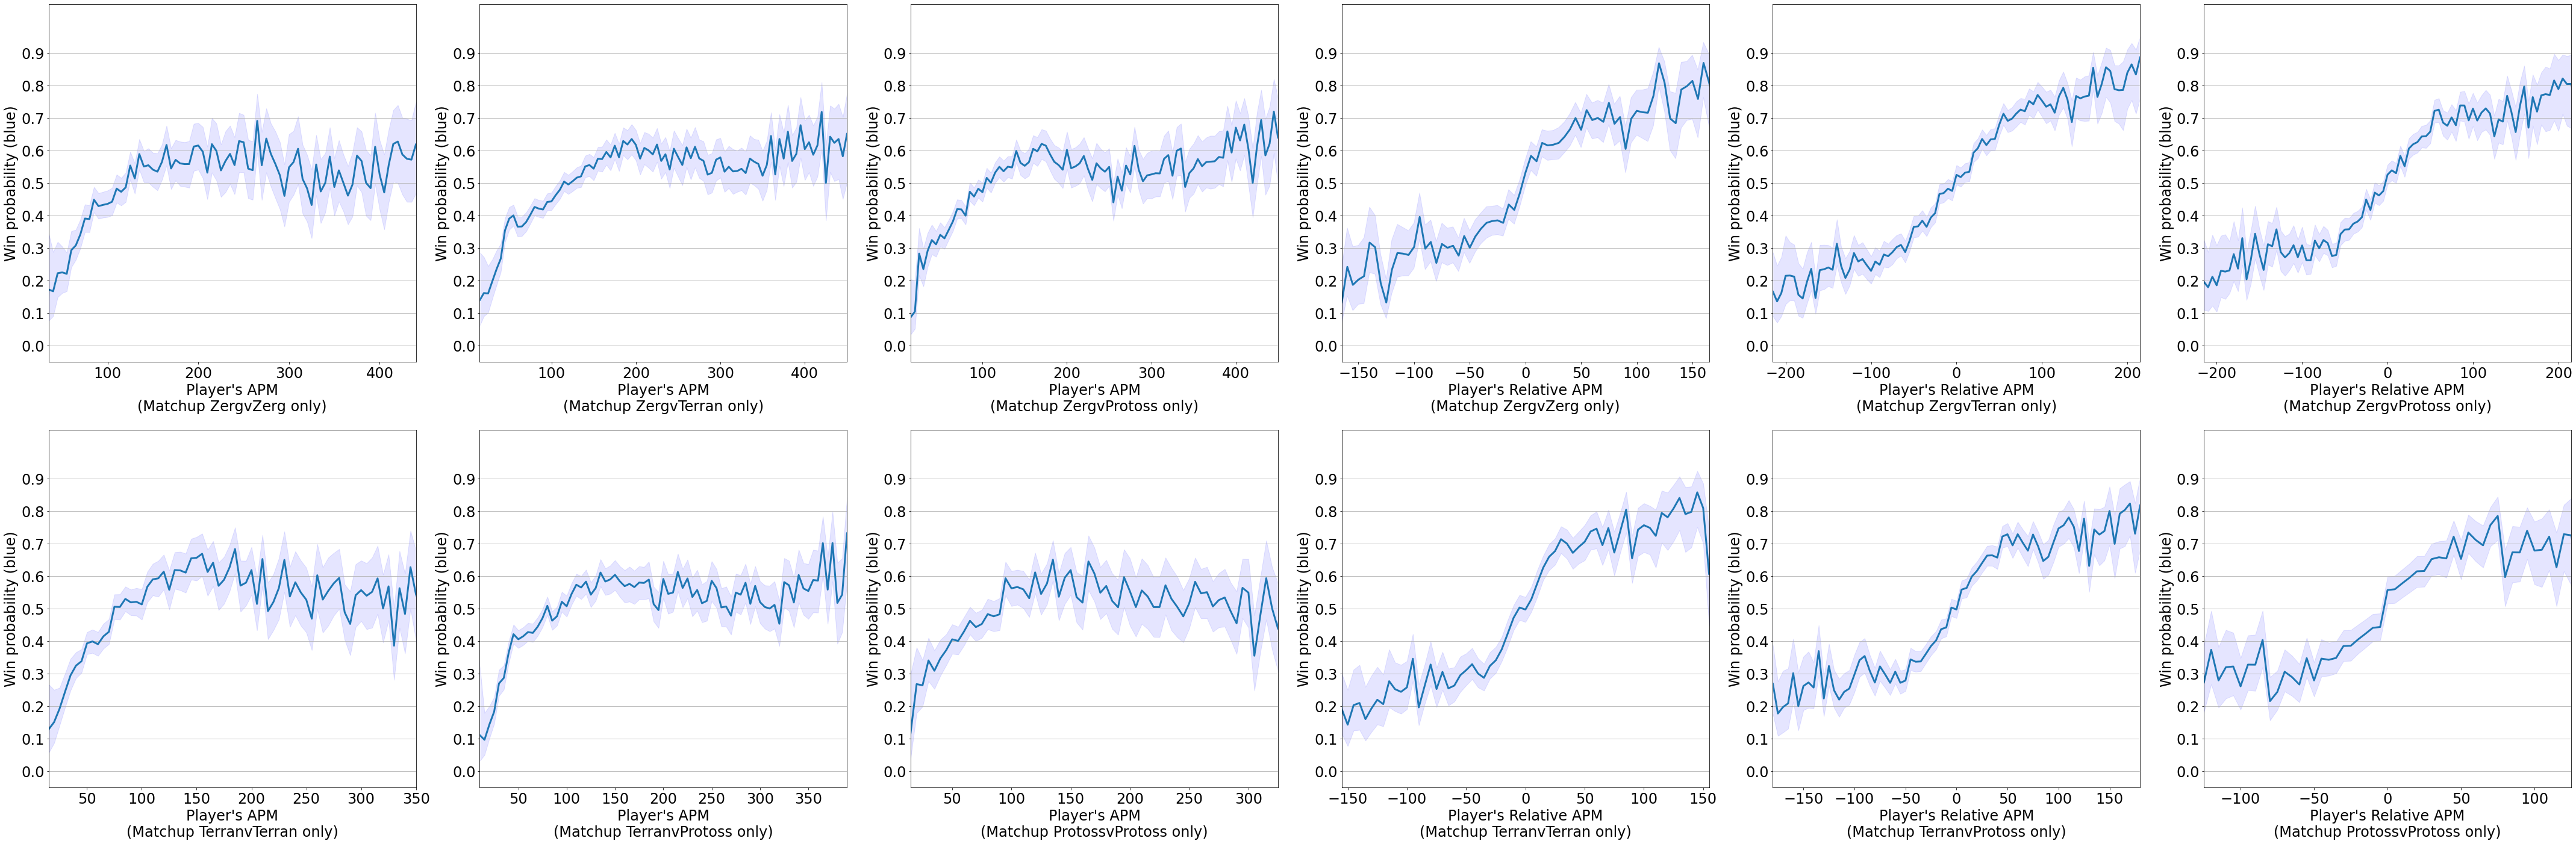

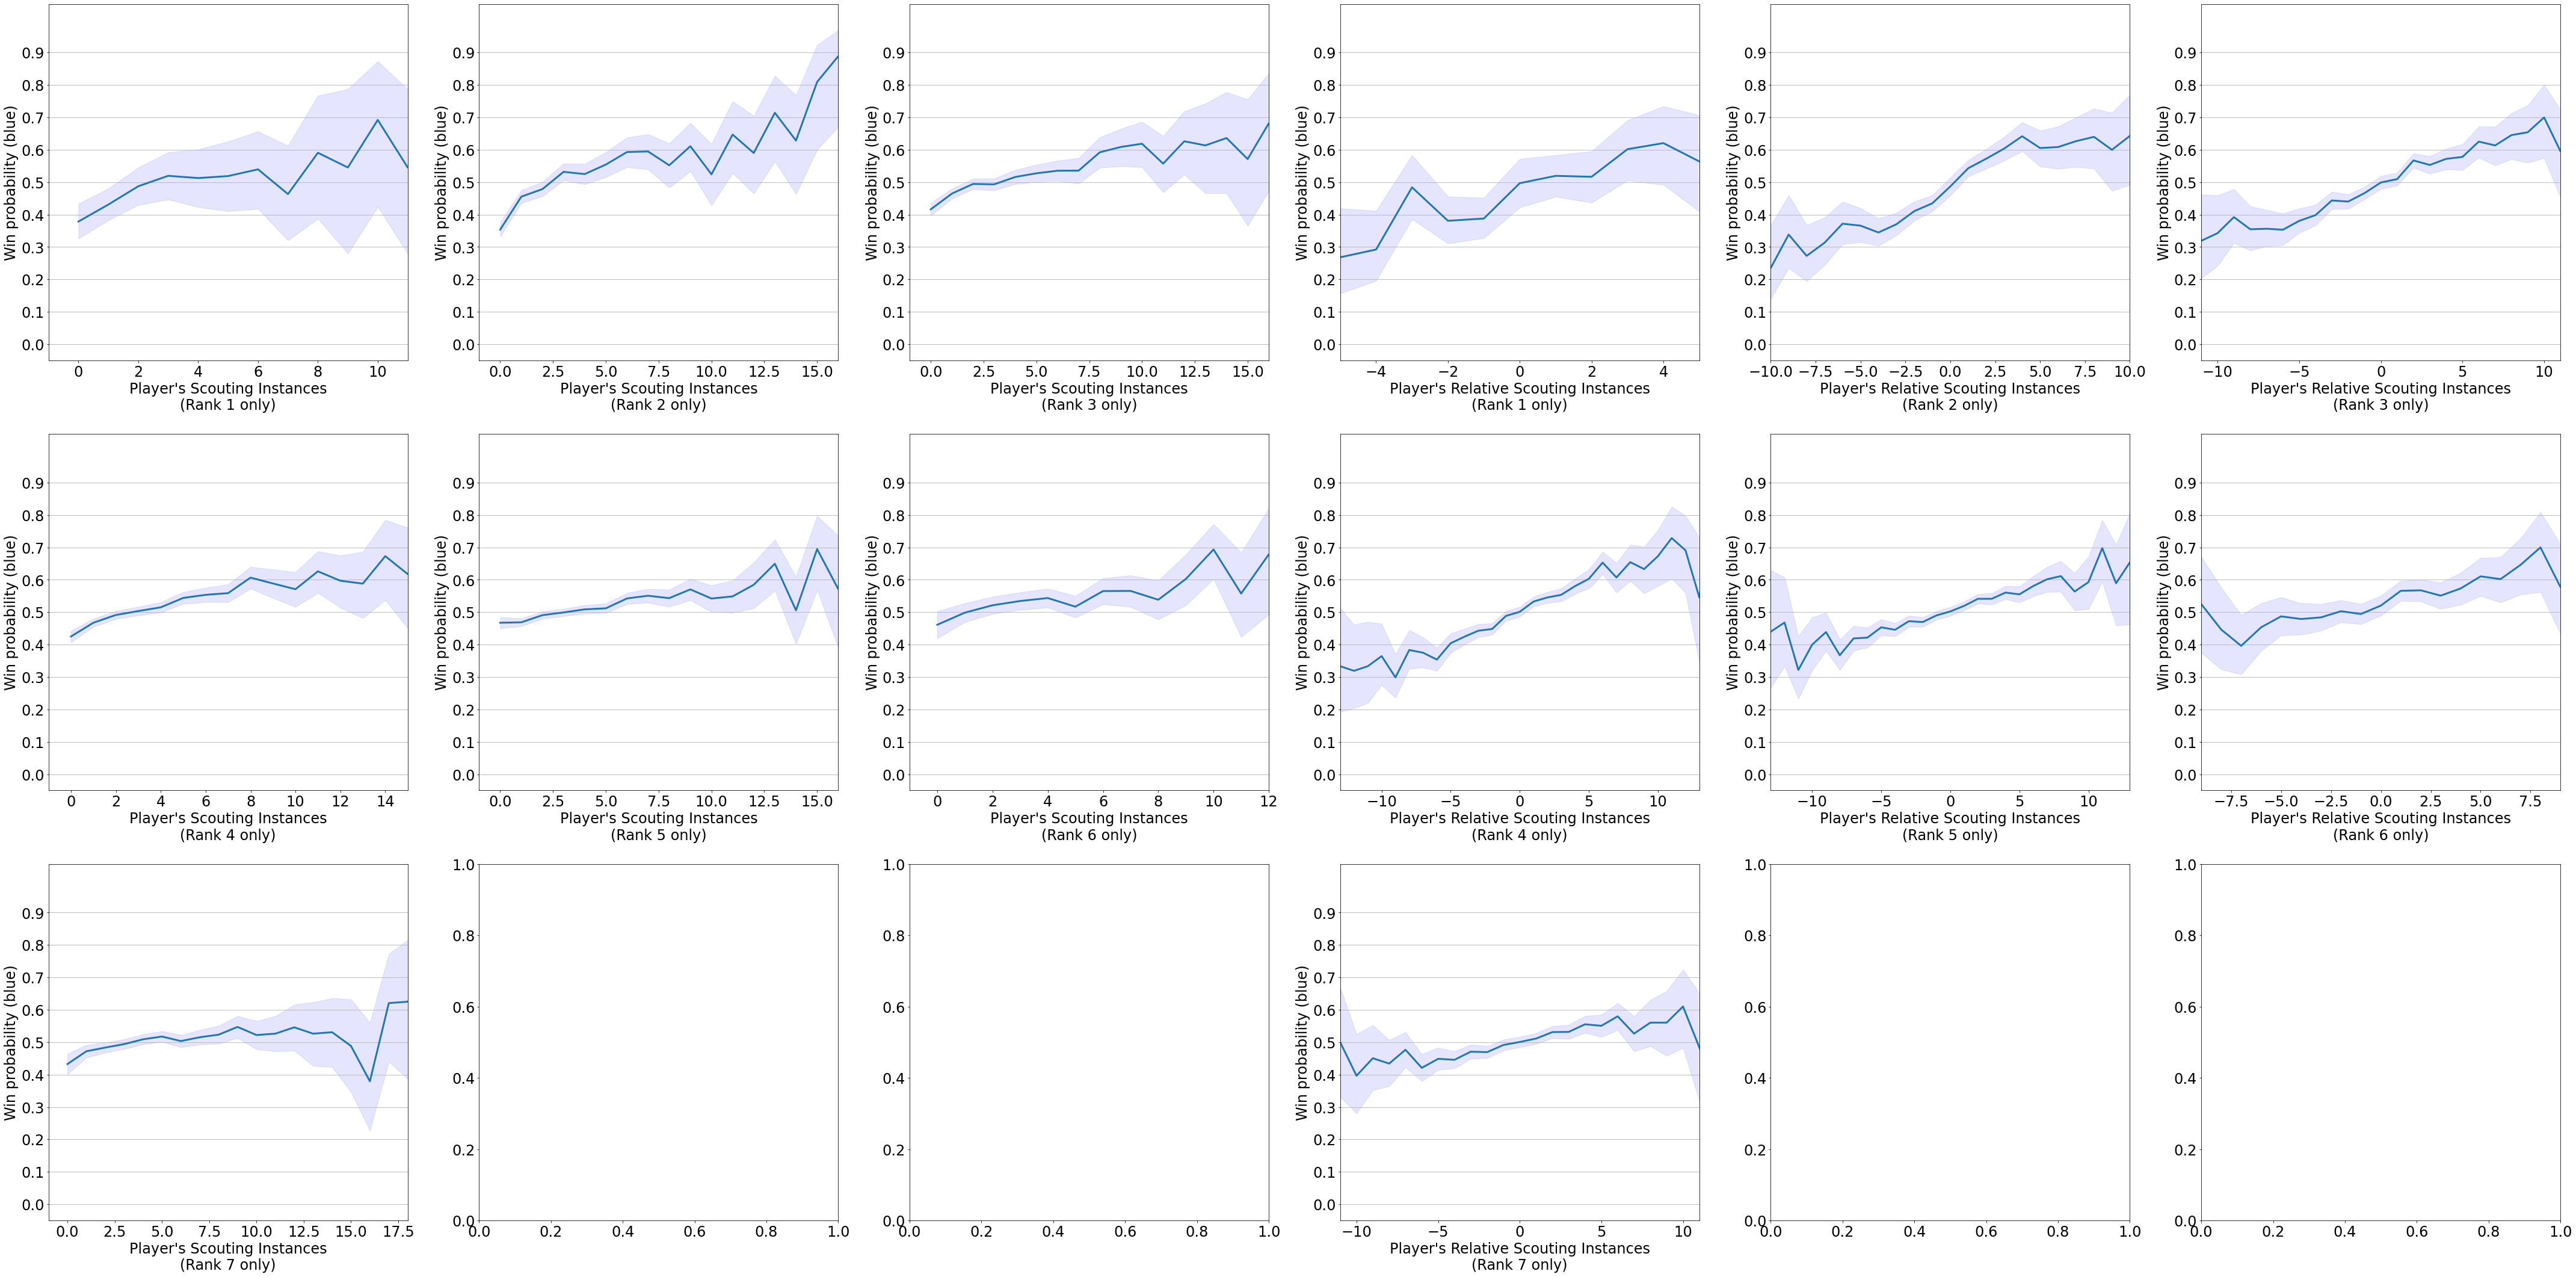

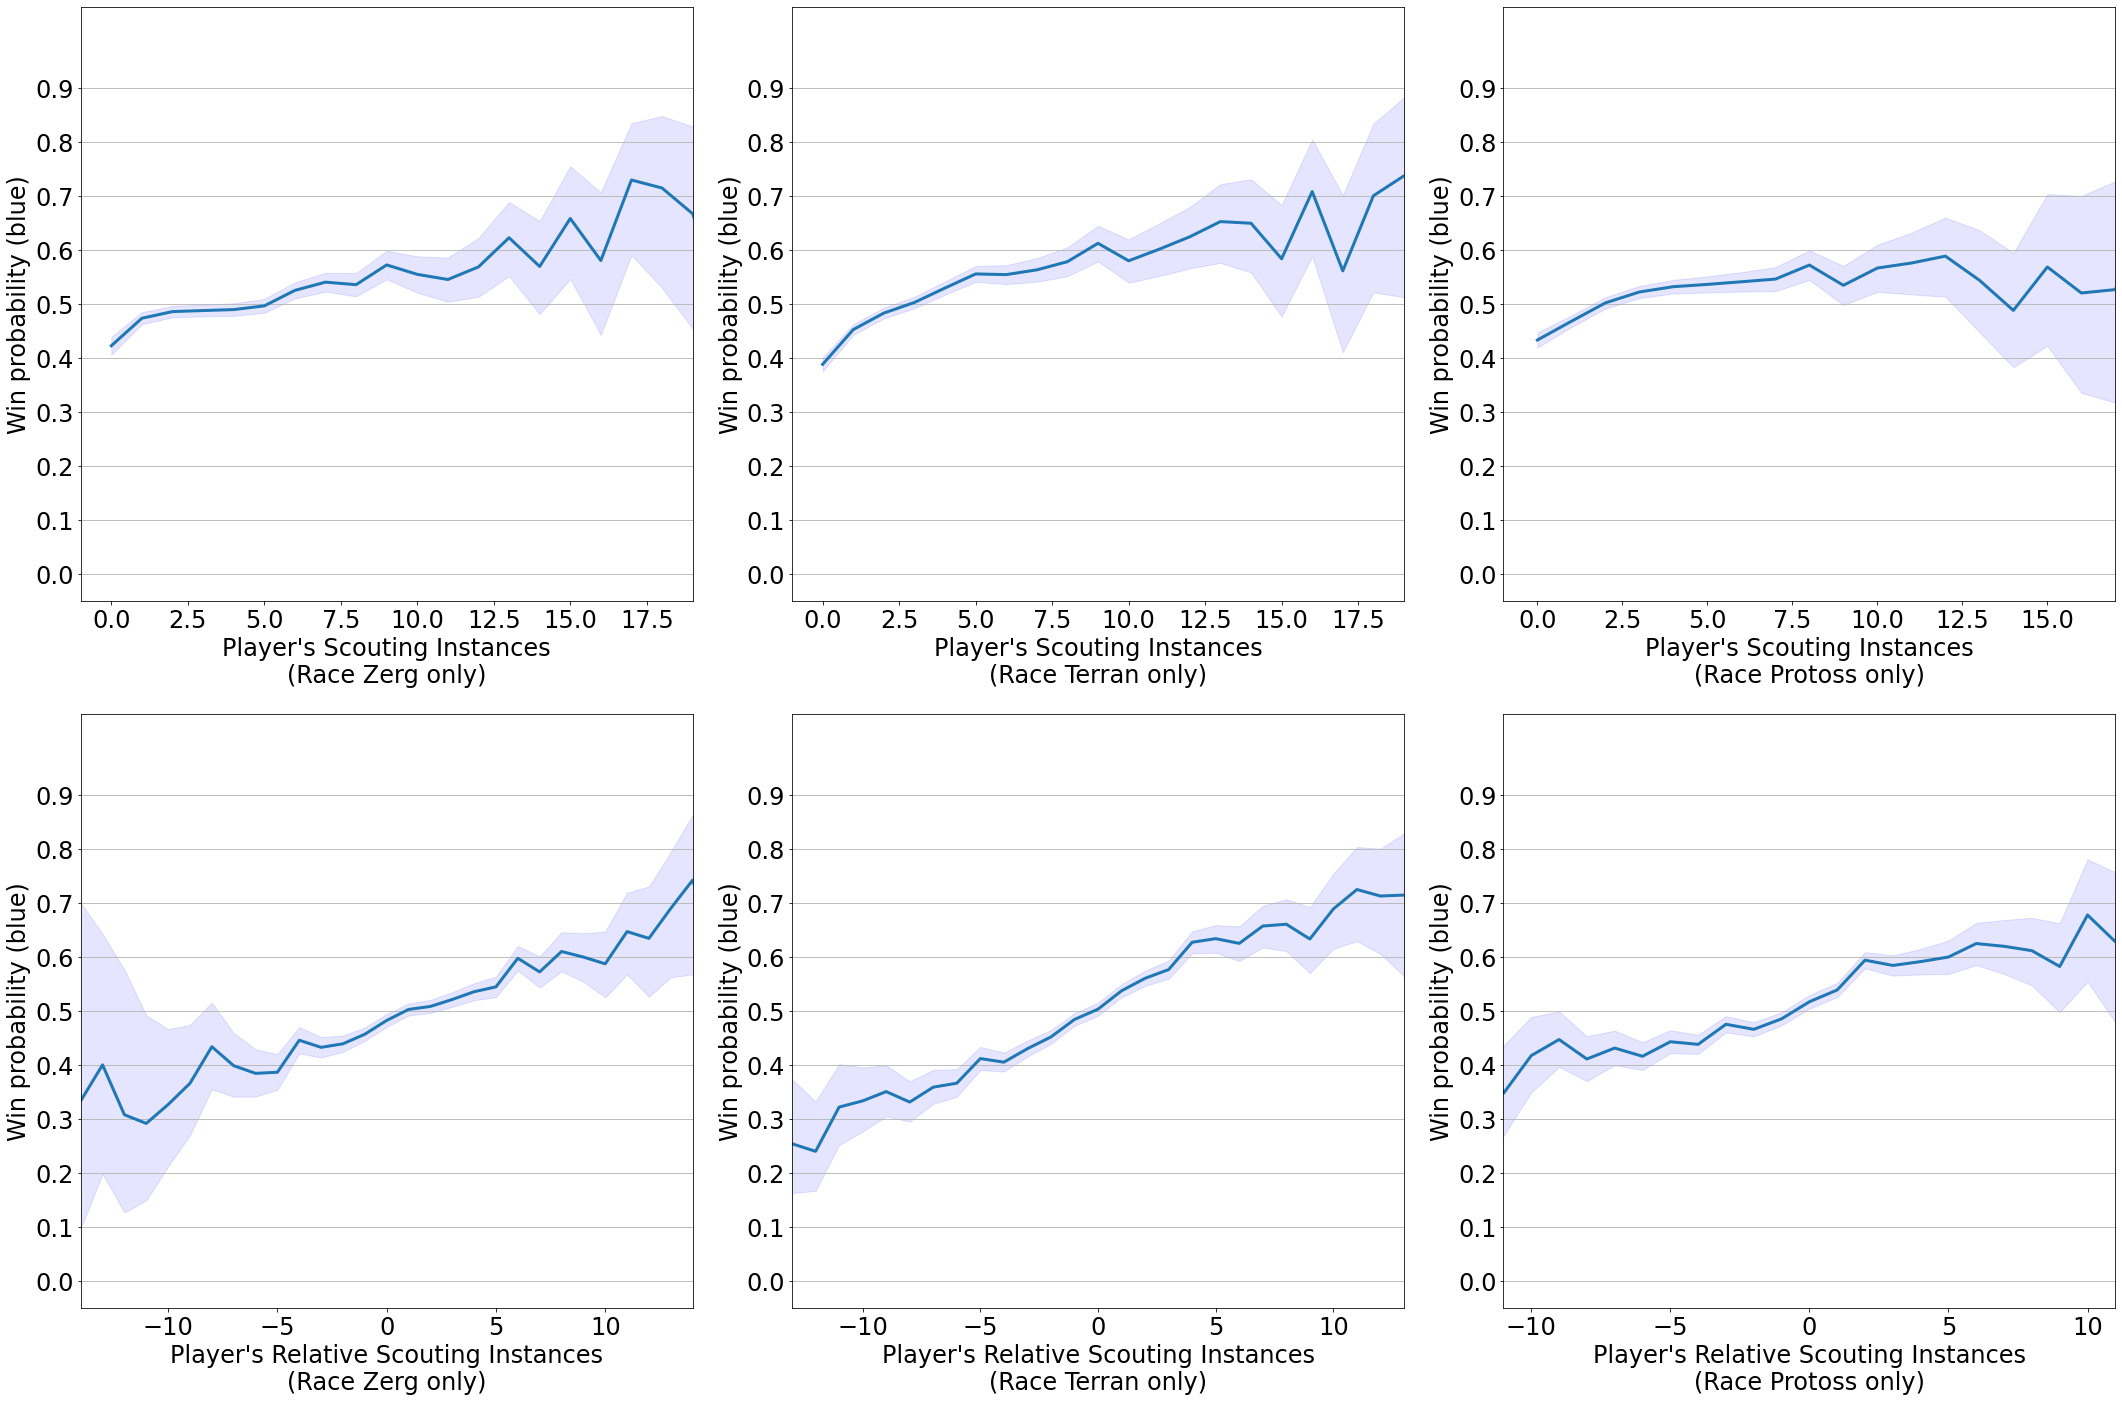

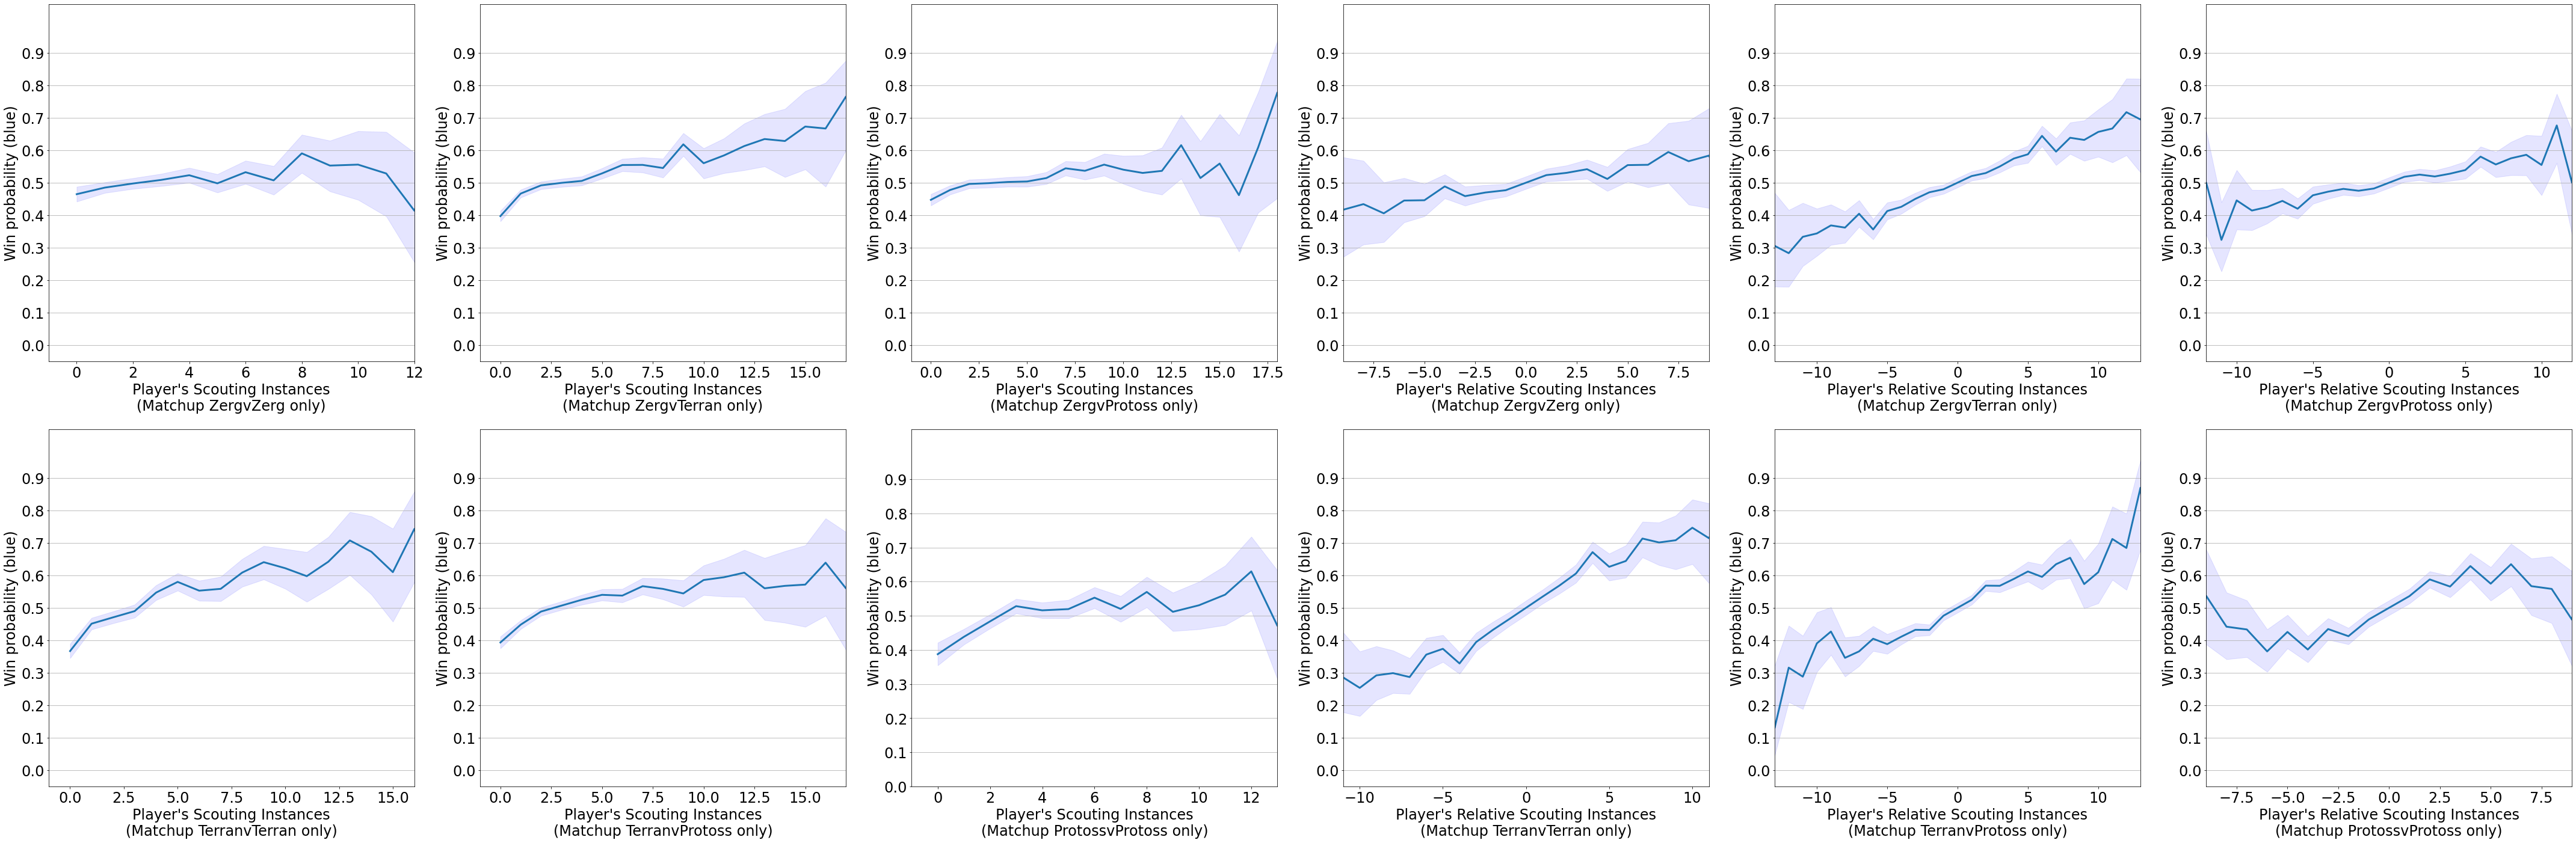

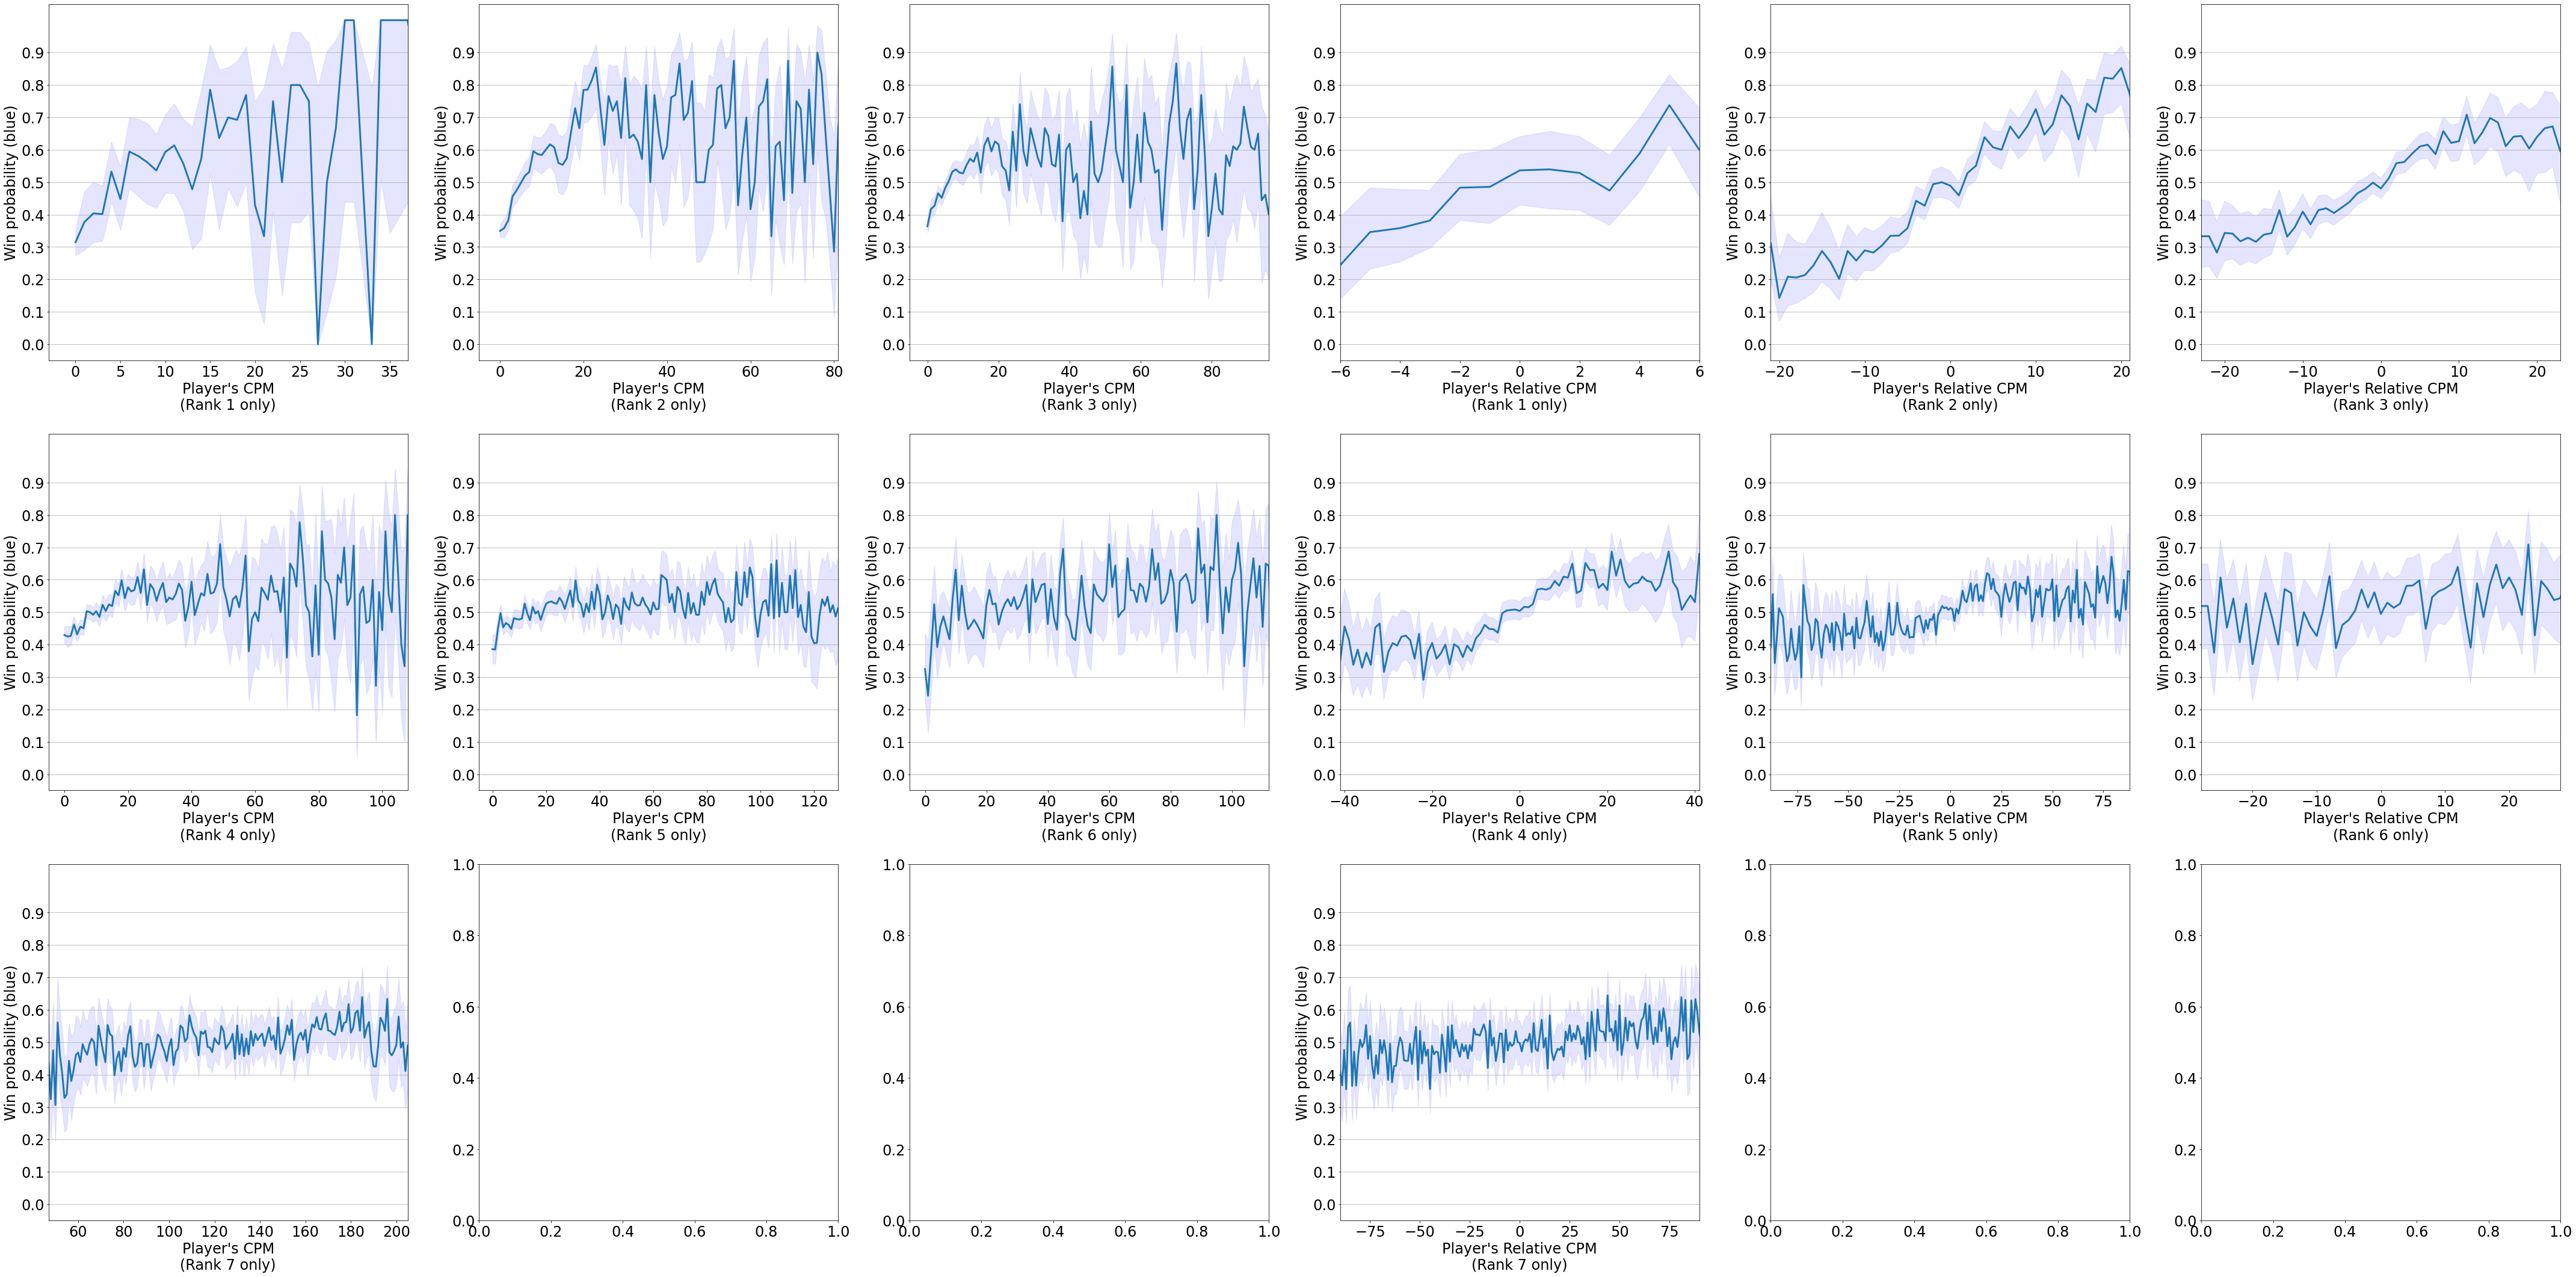

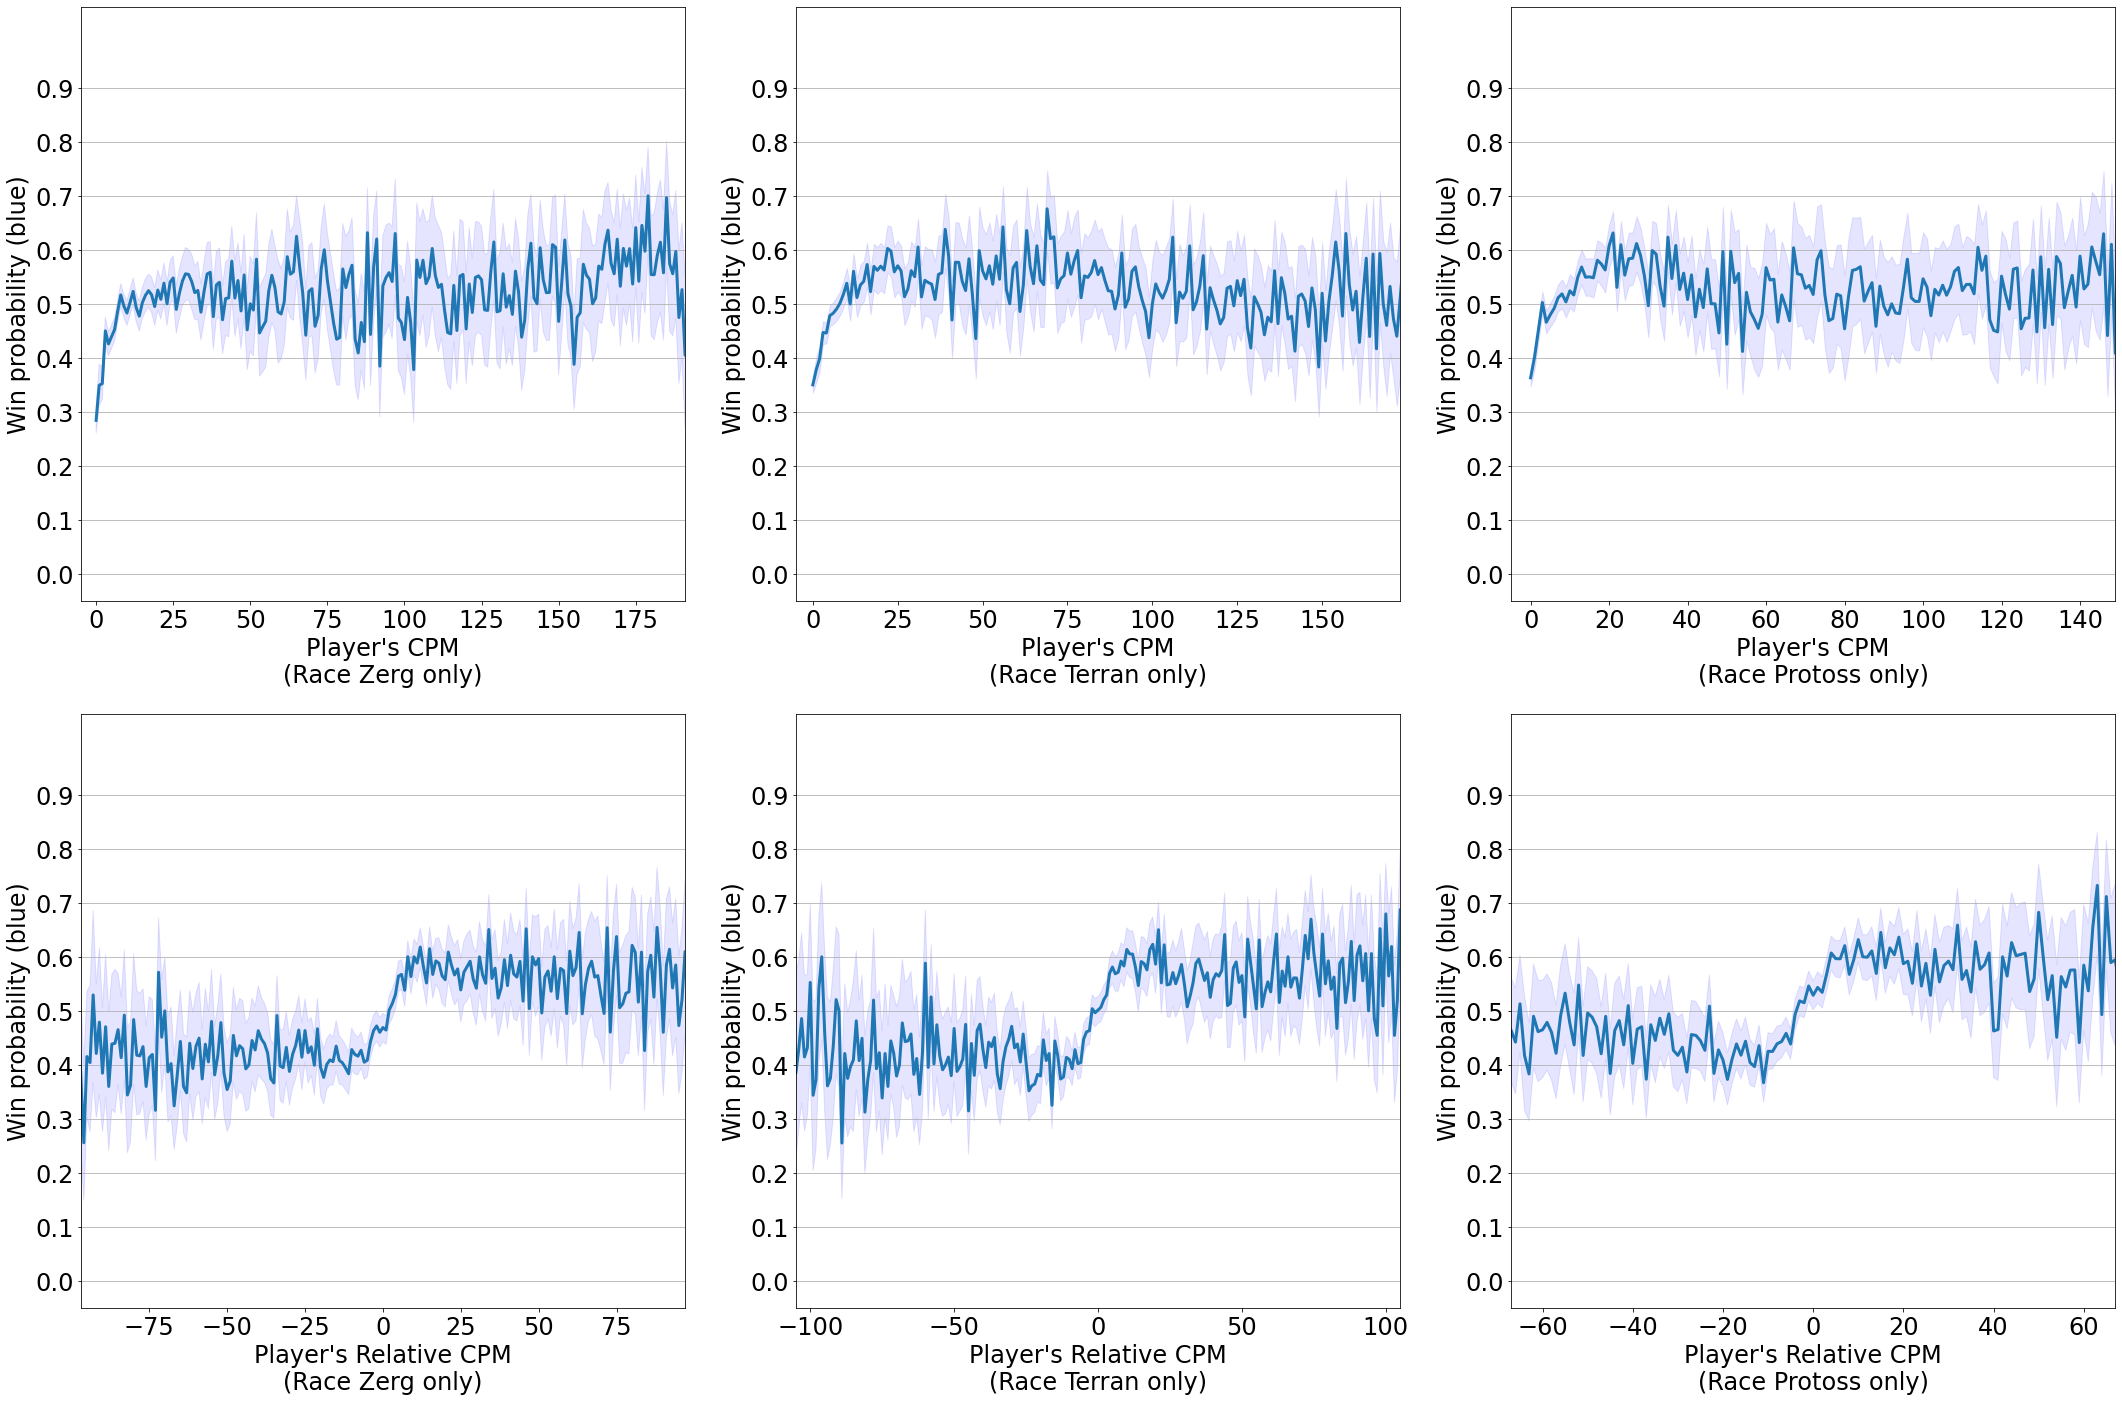

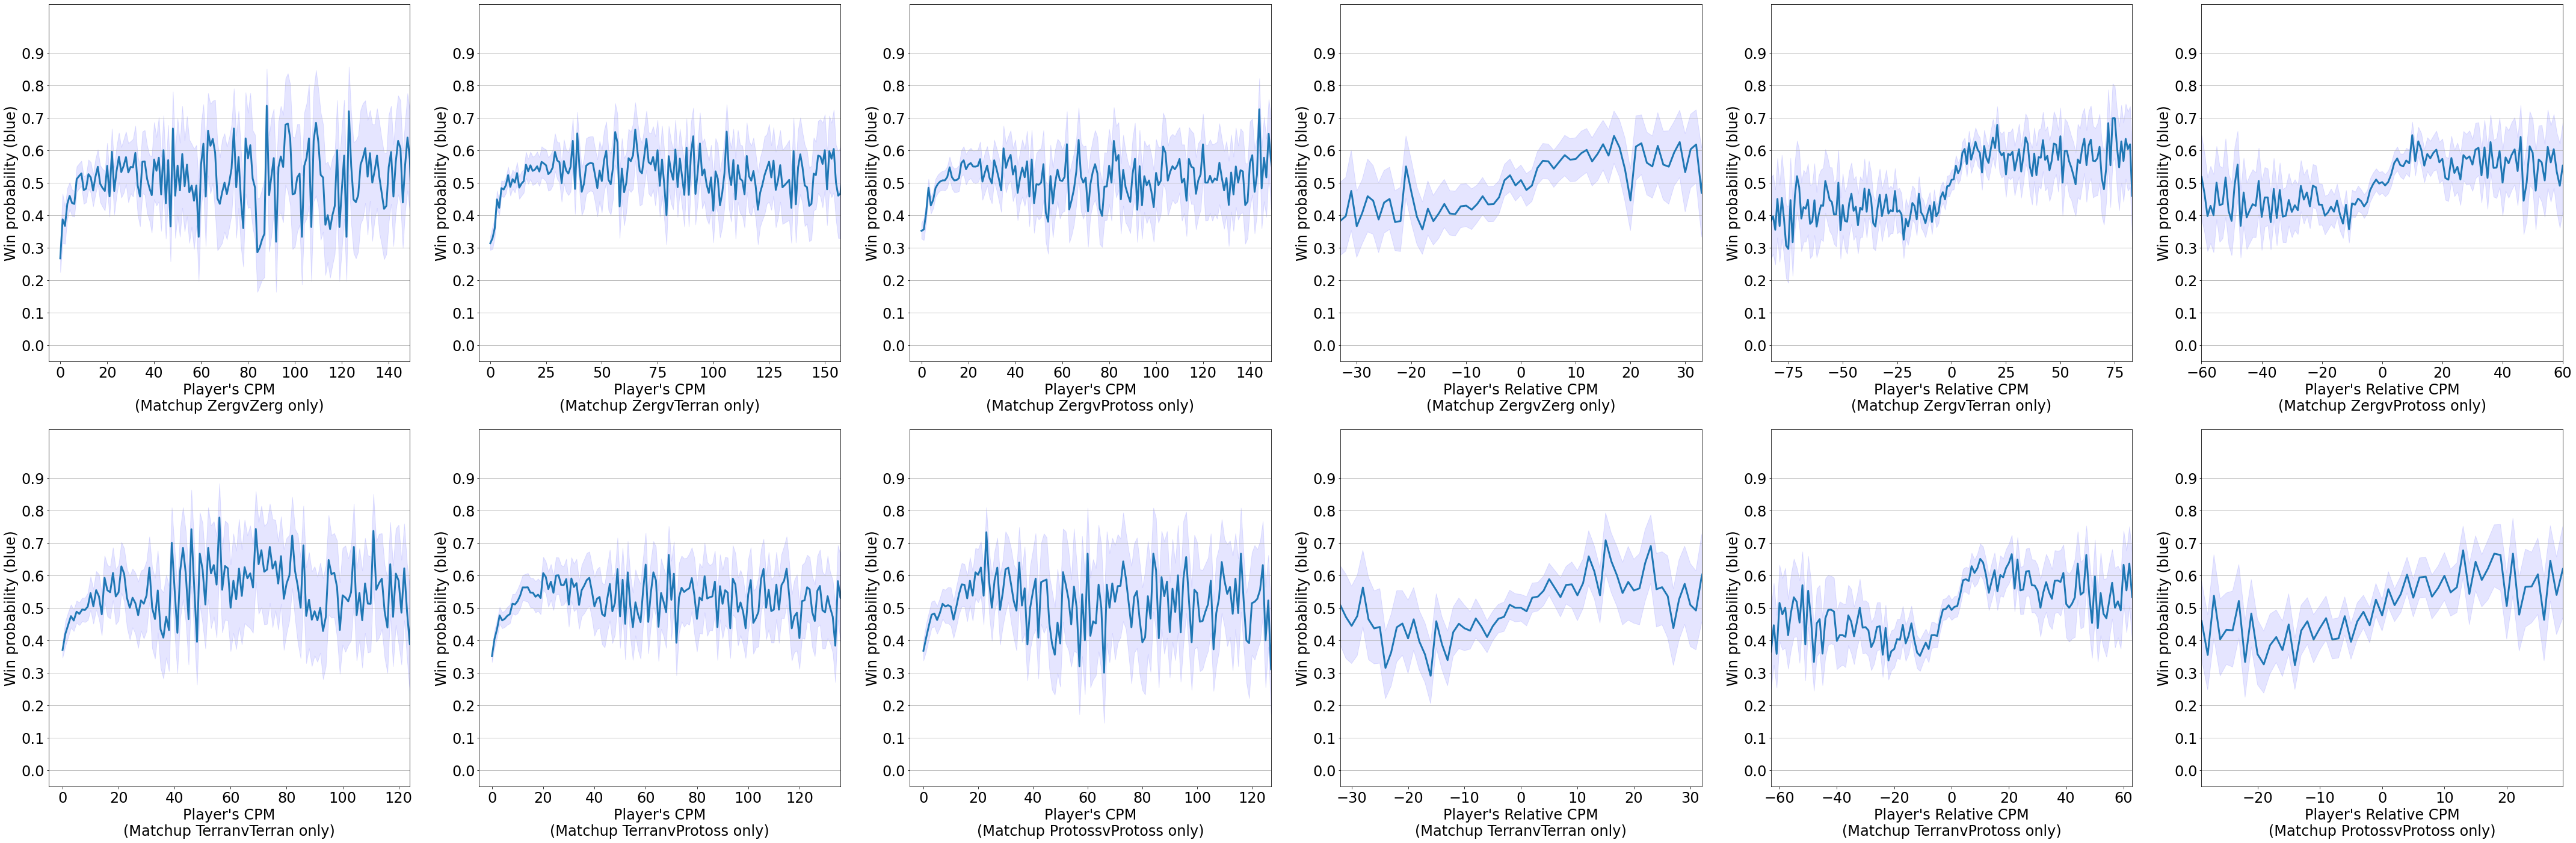

In [208]:
from itertools import combinations_with_replacement
from textwrap import wrap
from statsmodels.stats.proportion import proportion_confint

def make_win_plot(ax, wins, xstart, xend, xlabel):
    x = np.array([val for val, w in wins.items()])
    y = np.array([(sum(w)/len(w)) for a, w in wins.items()])
    ci_lowers, ci_uppers = zip(*[proportion_confint(sum(w), len(w), method='wilson') for a, w in wins.items()])
    ax.plot(x, y, linewidth=3)
    ax.fill_between(x, ci_lowers, ci_uppers, color='b', alpha=.1)
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.grid(axis='y')
    ax.set_xlim(xstart, xend)
    ax.set_ylabel("Win probability (blue)")
    ax.set_xlabel(xlabel)

def make_win_plots(lookup: Dict[Tuple[str, str], LookupEntry], data_label: str, ax1, ax2, 
                   pred=lambda x: True, sublabel=None):
    if sublabel:
        data_label = f"{data_label}\n({sublabel} only)"
    abs_wins = {val: [w for _,w in wins] for val, wins in groupby(sorted([(entry.absolute, entry.win) for entry in lookup.values() if pred(entry)]), lambda x: x[0])}
    rel_wins = {val: [w for _,w in wins] for val, wins in groupby(sorted([(entry.relative, entry.win) for entry in lookup.values() if pred(entry)]), lambda x: x[0])}

    start = list(abs_wins.keys())[next(i for i, (a, w) in enumerate(abs_wins.items()) if 
                                       len(w) >= 50)]
    limit = list(abs_wins.keys())[next(i for i, (a, w) in enumerate(abs_wins.items()) if 
                                       len(w) < 50 and a > np.median(list(abs_wins.keys())))]
    make_win_plot(ax1, abs_wins, start - min(5, limit//10), limit, f"Player's {data_label}")
    
    limit = list(rel_wins.keys())[next(i for i, (a, w) in enumerate(rel_wins.items()) if 
                                       len(w) < 50 and a > 0)]
    make_win_plot(ax2, rel_wins, -limit, limit, f"Player's Relative {data_label}")
    
def make_overall_plots(lookup, data_label):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
    make_win_plots(lookup, data_label, ax1, ax2)
    plt.tight_layout()
    
def make_rank_plots(lookup, data_label):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, axs = plt.subplots(3, 6, figsize=(60,30))
    for rank in range(1, 8):
        row = (rank - 1) // 3
        col = (rank - 1) % 3
        make_win_plots(lookup, data_label, axs[row, col], axs[row, col + 3], lambda x: x.rank == rank, f"Rank {rank}")
    plt.tight_layout()
    
def make_race_plots(lookup, data_label):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, axs = plt.subplots(2, 3, figsize=(30,20))
    for i, race in enumerate(["Zerg", "Terran", "Protoss"]):
        make_win_plots(lookup, data_label, axs[0, i], axs[1, i], lambda x: x.race == race, f"Race {race}")
    plt.tight_layout()
    
def make_matchup_plots(lookup, data_label):
    plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
    fig, axs = plt.subplots(2, 6, figsize=(60,20))
    for i, (r1, r2) in enumerate(combinations_with_replacement(["Zerg", "Terran", "Protoss"], 2)):
        row = i // 3
        col = i % 3
        make_win_plots(lookup, data_label, axs[row, col], axs[row, col + 3], 
                       lambda x: (x.race == r1 and x.opp_race == r2) or (x.race == r2 and x.opp_race == r1), 
                       f"Matchup {r1}v{r2}")
    plt.tight_layout()
make_rank_plots(apm_lookup, "APM")
make_race_plots(apm_lookup, "APM")
make_matchup_plots(apm_lookup, "APM")

make_rank_plots(scouting_lookup, "Scouting Instances")
make_race_plots(scouting_lookup, "Scouting Instances")
make_matchup_plots(scouting_lookup, "Scouting Instances")

make_rank_plots(cpm_lookup, "CPM")
make_race_plots(cpm_lookup, "CPM")
make_matchup_plots(cpm_lookup, "CPM")

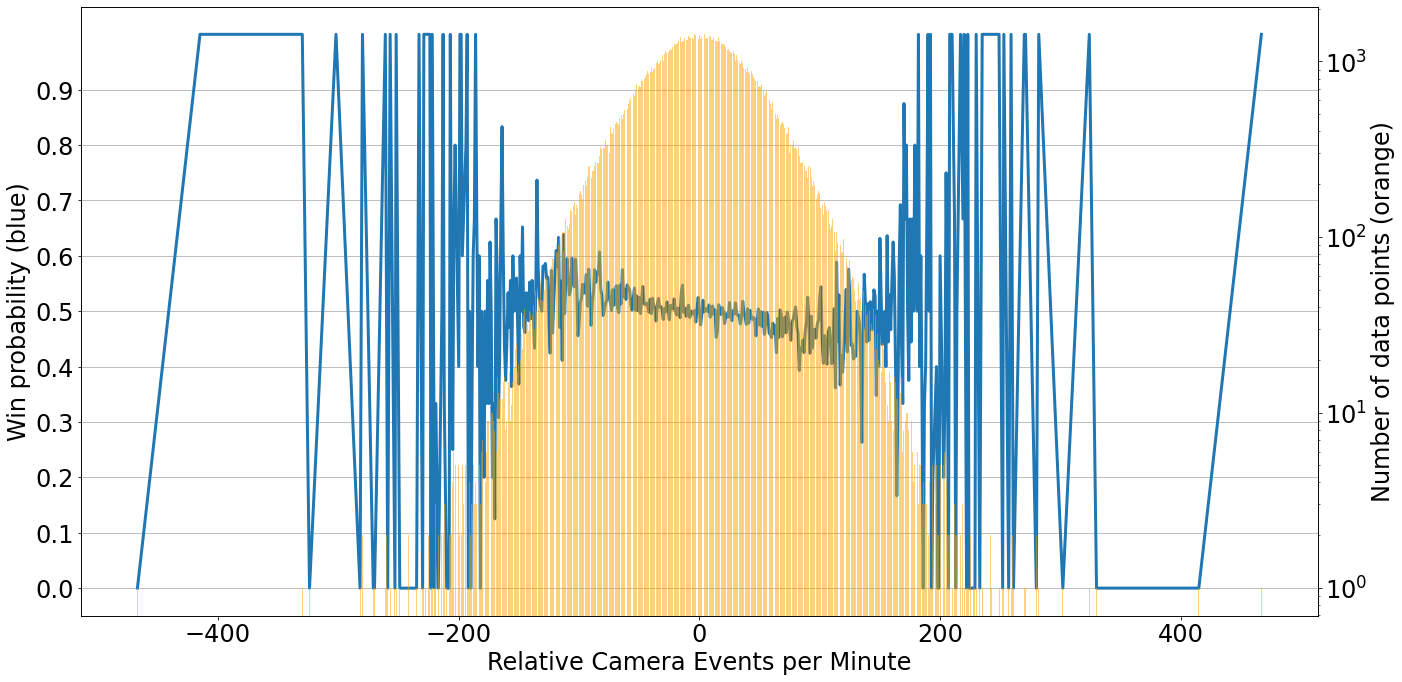

In [81]:
with open("cps2021-07-29.csv") as fp:
    c = csv.DictReader(fp)
    lines = [l for l in c]

BUCKET_SIZE = 1
rel_cps = {}
for line in lines:
    rel_cps[(line['UID1'], line['GameID'])] = (float(line["CameraPerSec1"])*60//BUCKET_SIZE*BUCKET_SIZE - float(line["CameraPerSec2"])*60//BUCKET_SIZE*BUCKET_SIZE, 1 if line["Winner"] == '1' else 0)
    rel_cps[(line['UID2'], line['GameID'])] = (float(line["CameraPerSec2"])*60//BUCKET_SIZE*BUCKET_SIZE - float(line["CameraPerSec1"])*60//BUCKET_SIZE*BUCKET_SIZE, 1 if line["Winner"] == '2' else 0)
    
cps_wins = {cps: [int(w) for a,w in wins] for cps, wins in groupby(sorted([(cps, win) for (uid, game), (cps, win) in rel_cps.items()]), lambda x: x[0])}

plt.rcParams.update({'font.size': 24, 'figure.facecolor': 'white'})
fig, ax = plt.subplots(figsize=(20,10))

ax.plot([a for a, w in cps_wins.items()], [(sum(w)/len(w)) for a, w in cps_wins.items()], linewidth=3)
ax.set_yticks(np.arange(0, 1, 0.1))
# ax.set_xlim(-100, 100)
# ax.set_xticks(np.arange(-500, 500, APM_BUCKET_SIZE))
ax.grid(axis='y')
ax_bar = ax.twinx()
ax_bar.bar(list(cps_wins.keys()), [len(w) for a, w in cps_wins.items()], color='orange', alpha=0.5)
ax_bar.set_yscale('log')
ax.set_ylabel("Win probability (blue)")
ax_bar.set_ylabel("Number of data points (orange)")
ax.set_xlabel("Relative Camera Events per Minute")
plt.tight_layout()

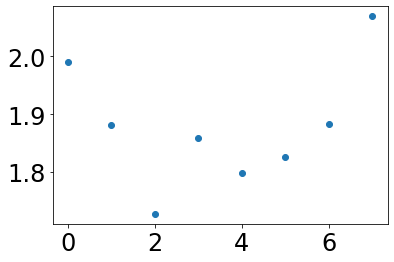

In [93]:
c1 = {key: [float(x['CameraPerSec1']) for x in g] for key, g in groupby(sorted(lines, key=lambda x: x['Rank1']), lambda x: x['Rank1'])}
c2 = {key: [float(x['CameraPerSec2']) for x in g] for key, g in groupby(sorted(lines, key=lambda x: x['Rank2']), lambda x: x['Rank2'])}
c = {k1: g1 + g2 for ((k1, g1), (k2, g2)) in zip(c1.items(), c2.items())}

plt.scatter([int(k) for k in c], [np.mean(v) for v in c.values()])

([<matplotlib.axis.XTick at 0x19039fe50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

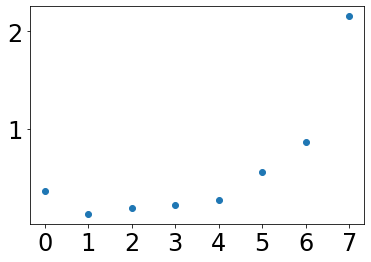

In [112]:
d = sorted([(key, [float(x['CPS']) for x in g]) for key, g in groupby(sorted([s for a in stats.values() for s in a], key=lambda x: x['Rank']), lambda x: x['Rank'])], key=lambda x: x[0])
plt.scatter([int(a) if a != 'nan' else 0 for a, _ in d], [np.mean(v) for _, v in d])
plt.xticks(np.arange(0, 8, 1))